In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [3]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [4]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [6]:
test_batch_size = 1000
batch_size = 64
epochs = 2
lr = 0.1
gamma = 0.7
seed = 1
no_cuda = False
log_interval = 1000
save_model = True
use_cuda = True if torch.cuda.is_available() else False

In [8]:
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [9]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

In [10]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [11]:
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.327989

Test set: Average loss: 0.0894, Accuracy: 9724/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.071884

Test set: Average loss: 0.0567, Accuracy: 9812/10000 (98%)



In [12]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [13]:
print(example_targets.shape)
print(example_data.shape)

torch.Size([1000])
torch.Size([1000, 1, 28, 28])


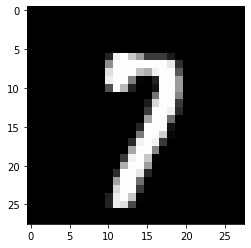

In [14]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.imshow(example_data[0][0], cmap='gray', interpolation='none')

In [15]:
grads = {}
def save_grad(name):
    def hook(grad):
        grads[name] = grad
    return hook

In [16]:
x = example_data[0,:,:,:].unsqueeze_(0).requires_grad_(True)
print(x.shape)

y = example_targets[0]

torch.Size([1, 1, 28, 28])


In [17]:
y_hat = model(x.to(device))
y_hat.shape

torch.Size([1, 10])

In [18]:
y_hat.argmax()

tensor(7, device='cuda:0')

### step by step derivatives

In [22]:
# df/dx
ddx, = torch.autograd.grad(model(x.to(device)).mean(), x, create_graph=True)
print(ddx.shape)

torch.Size([1, 1, 28, 28])


In [24]:
ddx.mean().backward()
# x.grad = d^2 f(x)/dx^2

In [25]:
#d^2 f(x)/dx^2
print(x.grad.shape)

torch.Size([1, 1, 28, 28])


In [26]:
### taylor series
str("P(x) = f(a) + (df(a)/dx)(x-a)/1! + (d^2f(a)/dx^2)(x-a)^2/2! + ...")

'P(x) = f(a) + (df(a)/dx)(x-a)/1! + (d^2f(a)/dx^2)(x-a)^2/2! + ...'

In [27]:
y_hat.shape

torch.Size([1, 10])

In [28]:
# f'(x)
ddx.shape

torch.Size([1, 1, 28, 28])

In [29]:
# f''(x)
x.grad.shape

torch.Size([1, 1, 28, 28])

In [43]:
# if we consider initial x to be 0
# gradient_terms = ddx*x + x.grad*(x.pow(2))
# gradient_terms.shape

In [32]:
class DynamicGNoise(nn.Module):
    def __init__(self, shape, std=0.05):
        super().__init__()
        self.noise = torch.zeros(shape).requires_grad_(True)
        self.std   = std
        
    def forward(self, x):
#         if not self.training: return x
        self.noise.data.normal_(0, std=self.std)
        
        print(x.size(), self.noise.size())
        return x + self.noise

In [33]:
noise = DynamicGNoise((1,1,28,28)).to(device)

In [44]:
x_noised = noise(x)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


In [45]:
x_noised.shape

torch.Size([1, 1, 28, 28])

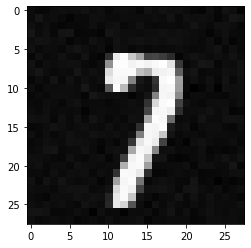

In [46]:
plt.imshow(x_noised.squeeze(0).squeeze(0).detach().numpy(), cmap='gray', interpolation='none')

In [47]:
f = model(x_noised.to(device))

In [49]:
gradient_terms = ddx * (x_noised - x) + x.grad * ((x_noised - x) ** 2)

In [50]:
gradient_terms.shape

torch.Size([1, 1, 28, 28])

In [51]:
gradient_terms_reshaped = model(term.cuda() if torch.cuda.is_available() else term)

In [52]:
taylorSeries_formula = f + gradient_terms_reshaped

### Verify the formula

In [54]:
print("Original|", y_hat.argmax())
print("Noised|", taylorSeries_formula.argmax())

Original| tensor(7, device='cuda:0')
Noised| tensor(7, device='cuda:0')
